In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date

'2017-08-23'

            prcp
date            
2016-08-23  0.00
2016-08-24  0.08
2016-08-25  0.08
2016-08-26  0.00
2016-08-27  0.00
...          ...
2017-08-17  0.13
2017-08-19  0.09
2017-08-21  0.56
2017-08-22  0.50
2017-08-23  0.45

[2021 rows x 1 columns]


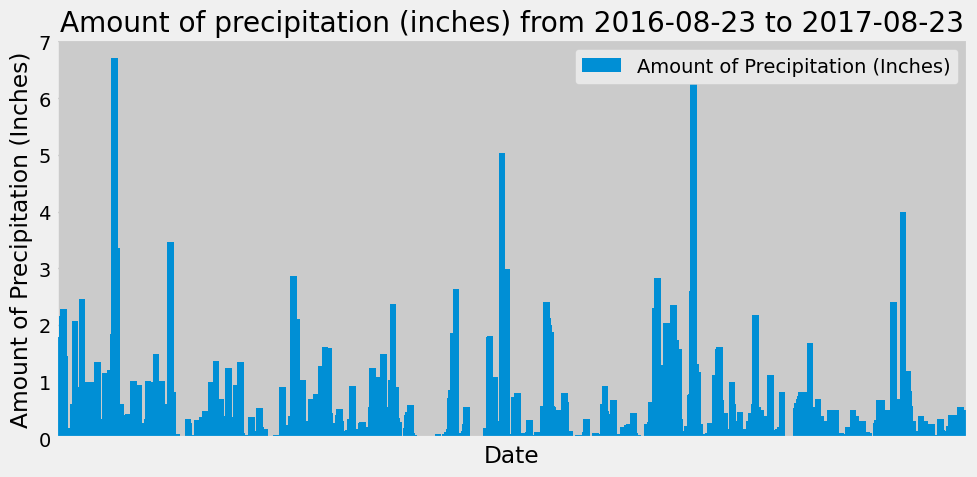

In [17]:
from dateutil.relativedelta import relativedelta

# Design a query to retrieve the last 12 months of precipitation data and plot the results.

# Calculate the date 1 year ago from the last data point in the database.
last_measurement_data_point_tuple = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
(latest_date, ) = last_measurement_data_point_tuple
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')
latest_date = latest_date.date()
date_year_ago = latest_date - relativedelta(years=1)

# Perform a query to retrieve the data and precipitation scores.
data_from_last_year = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= date_year_ago).all()

# Save the query results as a Pandas DataFrame.
last_year_data_df = pd.DataFrame(data_from_last_year, columns=['date', 'prcp'])

# Drop null values (if any).
last_year_data_df = last_year_data_df.dropna(how="any")

# Set the index to the date column.
last_year_data_df = last_year_data_df.set_index("date")
print(last_year_data_df)

# Sort the dataframe by date.
last_year_data_df = last_year_data_df.sort_values(by=['date'])

# Use pandas plotting with matplotlib to plot the data.

# Plot it.
prcp_plot = last_year_data_df.plot(kind="bar", figsize=(10, 5), width=15)

# Add legend
prcp_plot.legend(["Amount of Precipitation (Inches)"], loc="upper right")

# Add labels to axes.
prcp_plot.set_xlabel("Date")
prcp_plot.set_ylabel("Amount of Precipitation (Inches)")

# Set a title for the chart
prcp_plot.set_title(f"Amount of precipitation (inches) from {date_year_ago} to {latest_date}")

plt.tick_params(
    axis='x',         
    which='both',    
    bottom=False,      
    top=False,        
    labelbottom=False
)

# Tighten the graph up so it displays nicely.
plt.tight_layout()

# Add grid lines.
prcp_plot.grid(zorder=1)

# Save figure
plt.savefig(f"./Images/precipitation_data_from_{date_year_ago}_to_{latest_date}.png", bbox_inches='tight')

# Show graph.
plt.show()

In [18]:
# Use Pandas to calculate the summary statistics for the precipitation data
last_year_data_df.describe()

prcp
count  2021.000000
mean      0.177279
std       0.461190
min       0.000000
25%       0.000000
50%       0.020000
75%       0.130000
max       6.700000

# Exploratory Station Analysis

In [20]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [24]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
for station, count in active_stations:
    print(f"('{station}', {count}),")

('USC00519281', 2772),
('USC00519397', 2724),
('USC00513117', 2709),
('USC00519523', 2669),
('USC00516128', 2612),
('USC00514830', 2202),
('USC00511918', 1979),
('USC00517948', 1372),
('USC00518838', 511),


In [26]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = active_stations[0][0]  # Assuming active_stations contains the list of stations and their counts in descending order
temperature_data = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                    filter(Measurement.station == most_active_station_id).all()

# Print the results
print(f"Lowest Temperature: {temperature_data[0][0]}")
print(f"Highest Temperature: {temperature_data[0][1]}")
print(f"Average Temperature: {temperature_data[0][2]}")

Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


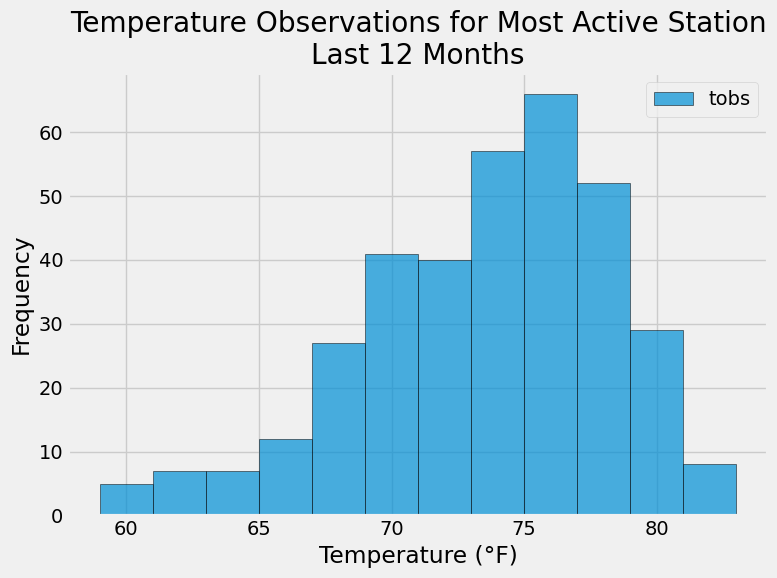

In [27]:
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
one_year_ago = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Query the temperature observations for the most active station in the last 12 months
temperature_data = session.query(Measurement.tobs).filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago).all()

# Convert the query results to a DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['tobs'])

# Plot the results as a histogram
plt.figure(figsize=(8, 6))
plt.hist(temperature_df['tobs'], bins=12, edgecolor='black', alpha=0.7)
plt.xlabel('Temperature (Â°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observations for Most Active Station\nLast 12 Months')
plt.legend(['tobs'], loc='best')
plt.tight_layout()
plt.show()

# Close Session

In [28]:
# Close Session
session.close()